# PROYECTO 2

## Sentiment & Emotions Labelled Tweets

## Definición del problema

Vamos a realizar la predicción de dos variables: Sentimientos (Negative, Neutral, Positive) y Emociones (Angry, Joy, Anticipation, Disgust, Sadness, Optimism). Para esto vamos a realizar un NLP para procesar los tweets recopilados y, a posterior, utilizar varios modelos de clasificación supervisado, para determinar cuál es el mejor, y obtener la mayor precisión posible al predecir cada una de estas variables.

Para empezar, es necesario contar con una base de datos lo suficientemente extensa como para generar una lista de palabras (bag of words) variada e incluirla en la matriz que necesitarán los modelos. Contamos con un dataset de casi 25.000 Tweets en el que se incluyen las variables "sentiment" y "emotion".

Necesitaremos, además, eliminar las palabras que no son útiles (etiquetas, hashtags, links), eliminar las palabras de menos de 2 caracteres, eliminar los "Stopwords" (añadimos las abreviaturas más utilizadas en Twitter), eliminar los "Hapaxes" (palabras que se repiten una sola vez), eliminar palabras que no contengan vocales, y, por último, reducir las palabras filtradas a su raíz más simple utilizando "Stemming". Añadiremos nuevas variables (columnas), para cada tweet, como la cantidad de etiquetas, la cantidad de hashtags, la cantidad de caracteres, la polaridad y la subjetividad (con TextBlob).

Nos reservaremos en 5% de los elementos del dataset para comprobar la efectividad de los modelos y así comparar cuál es más sencillo de predecir (Sentimientos o Emociones).

## Recopilación de Datos

- https://www.kaggle.com/datasets/ankitkumar2635/sentiment-and-emotions-of-tweets
- https://www.kaggle.com/datasets/aryansingh0909/elon-musk-tweets-updated-daily

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import time

import pickle as pkl
from textblob import TextBlob

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Leemos el DataFrame original
df_original = pd.read_csv("data/sentiment-emotion-labelled_Dell_tweets.csv")

df_tweets = df_original.copy()
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124
...,...,...,...,...,...,...,...,...,...
24965,24965,2022-01-01 02:02:04+00:00,1477097760931336198,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,Eodart,negative,0.682981,anger,0.906309
24966,24966,2022-01-01 01:57:34+00:00,1477096631300415496,@kite_real @GamersNexus @Dell I didn't really ...,Eodart,positive,0.743940,joy,0.951701
24967,24967,2022-01-01 01:36:36+00:00,1477091355629432833,Hey @JoshTheFixer here it is....27 4K UHD USB-...,Corleone250,neutral,0.654463,anticipation,0.471185
24968,24968,2022-01-01 01:31:30+00:00,1477090070830141442,@bravadogaming @thewolfpena @Alienware @intel ...,MrTwistyyy,neutral,0.794049,anticipation,0.747014


In [3]:
df_original.value_counts("sentiment", normalize = True)

sentiment
negative    0.422747
positive    0.294994
neutral     0.282259
dtype: float64

In [4]:
df_original.value_counts("sentiment")

sentiment
negative    10556
positive     7366
neutral      7048
dtype: int64

In [5]:
df_original.value_counts("emotion", normalize = True)*100

emotion
anger           30.116139
joy             25.334401
anticipation    20.708851
disgust         12.014417
sadness          5.318382
optimism         4.905887
fear             1.465759
surprise         0.136163
dtype: float64

In [6]:
df_original.value_counts("emotion")

emotion
anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
dtype: int64

## Exploratory Data Analysis (EDA) y Procesamiento de Datos.

In [7]:
import nltk
from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder

import unicodedata

In [8]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24970 entries, 0 to 24969
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       24970 non-null  int64  
 1   Datetime         24970 non-null  object 
 2   Tweet Id         24970 non-null  int64  
 3   Text             24970 non-null  object 
 4   Username         24970 non-null  object 
 5   sentiment        24970 non-null  object 
 6   sentiment_score  24970 non-null  float64
 7   emotion          24970 non-null  object 
 8   emotion_score    24970 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 1.7+ MB


In [9]:
# Quitamos columnas innecesarias
df_tweets.drop(["Unnamed: 0", "Tweet Id", "Username", "Datetime", "sentiment_score", "emotion_score"], axis = 1, inplace = True)

df_tweets

,Text,sentiment,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,neutral,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",positive,joy
3,@dell your customer service is horrible especi...,negative,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral,anger
...,...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,negative,anger
24966,@kite_real @GamersNexus @Dell I didn't really ...,positive,joy
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,neutral,anticipation
24968,@bravadogaming @thewolfpena @Alienware @intel ...,neutral,anticipation


In [10]:
# Cambiamos nombres a columnas "sentiment" y "emotion"
df_tweets = df_tweets.rename(columns = {"sentiment": "Sentimientos", "emotion": "Emociones"})
df_tweets

,Text,Sentimientos,Emociones
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,neutral,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",positive,joy
3,@dell your customer service is horrible especi...,negative,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral,anger
...,...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,negative,anger
24966,@kite_real @GamersNexus @Dell I didn't really ...,positive,joy
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,neutral,anticipation
24968,@bravadogaming @thewolfpena @Alienware @intel ...,neutral,anticipation


In [11]:
# .hapaxes
cadena_hapax = " ".join(df_tweets["Text"])
texto_nltk = nltk.Text(tokens = cadena_hapax.split())

# .FreqDist()
distribucion = nltk.FreqDist(samples = texto_nltk)

hapaxes = distribucion.hapaxes()

In [12]:
pd.DataFrame([len(x) for x in cadena_hapax.split()]).describe()

,0
count,667819.000000
mean,5.484339
std,3.835967
min,1.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,81.000000


In [13]:
media_carecteres = np.array([len(x) for x in cadena_hapax.split()]).mean()

In [14]:
# Contar "hashtags" y "arrobas"
df_tweets["@"] = [x.count("@") for x in df_tweets["Text"]]
df_tweets["#"] = [x.count("#") for x in df_tweets["Text"]]
df_tweets

,Text,Sentimientos,Emociones,@,#
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral,anticipation,6,1
1,@MK_habit_addict @official_stier @MortalKombat...,neutral,joy,5,1
2,"As @CRN celebrates its 40th anniversary, Bob F...",positive,joy,8,3
3,@dell your customer service is horrible especi...,negative,anger,2,0
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral,anger,4,0
...,...,...,...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,negative,anger,3,0
24966,@kite_real @GamersNexus @Dell I didn't really ...,positive,joy,3,0
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,neutral,anticipation,2,0
24968,@bravadogaming @thewolfpena @Alienware @intel ...,neutral,anticipation,10,0


In [15]:
# Función para limpiar el DataFrame de las palabras que no son útiles (etiquetados, hashtags, links, etc.)
def limpiar_texto(texto):
        
    texto = ''.join([unicodedata.normalize('NFKD', caracter).encode('ASCII', 'ignore').decode('utf-8') for caracter in texto])

    texto = texto.lower()

    # Descartamos las etiquetas, hashtags, links, etc.
    lista_nueva = list()
        
    lista_texto = texto.split()
        
    for i in lista_texto:
        
        if not i.startswith("@") | i.startswith(".") | i.startswith("http") | i.startswith("#"):
            
            lista_nueva.append(i)
            
    texto = " ".join(lista_nueva)
        
    tokens = nltk.word_tokenize(text = texto, language = "english")
    
    tokens = [i for i in tokens if i.isalpha()]
    
    # STOPWORDS
    stopwords = nltk.corpus.stopwords.words("english")
    
    # Añadimos palabras a la lista de STOPWORDS que hemos verificado que no se encuentran
    our_stopwords = ["dont", "cant", "isnt", "arent", "wasnt", "werent", "wouldnt", "mustnt", "wont", "shouldnt", 
                     "aint", "hadnt", "shant", "mightnt", "neednt", "hasnt", "havent", "imma", "omg", 'dm', 'cc',
                     'im', 'dc', 'bc', 'asap', 'btw', 'fyi', 'ceo', 'eta', 'tl', 'dr', 'tba', 'tbc', 'lol', 'omg',
                     'ily', 'ppl', 'idk', 'tbh', 'btw', 'thx', 'jk', 'fyi', 'brb', 'idc', 'tgif', 'bff', 'hbd', 'tmi',
                     'nvm', 'omw', 'hmu', 'yolo', 'bf', 'hth', 'nsfw', 'xoxo', 'ftf', 'afk', 'en', 'fa', 'ff', 'fb',
                     'gtg', 'ht', 'hth', 'imo', 'lmao', 'mt', 'mrt', 'pls', 'plz', 'pm', 'qt', 'rl', 'rofl', 'rolfmao',
                     'rpg', 'rt', 'thx', 'tl', 'tmb', 'tt', 'wtf', 'xd', 'icymi', 'imho', 'ihdk', 'irl', 'np', 'qotd']

    stopwords.extend(our_stopwords)
    
    lista_borrar = ["aa", "eee", "ii", "ooo", "uu", "xx", "sss", "ff", "hh",
                    "mmm", "yy", "ww", "rrr", "zzz", "vv", "jj", "kk", "lll", 
                    "qq", "ttt"]
    
    tokens_limpios = list()
    
    for token in tokens:

        if token not in stopwords:
            
            if len(token) > 2:
                    
                if not any(item in token for item in lista_borrar):
                    
                    tokens_limpios.append(token)
    
    # HAPAXES
    sin_hapax = list()
    
    for word in tokens_limpios:

        if word not in hapaxes:
            
            sin_hapax.append(word)

    sin_hapax = " ".join(sin_hapax)
    
    # LIMPIEZA EXTREMA VOL. 3: LA VENGANZA DE LOS SITH
    sin_nada = list()
    
    for word in sin_hapax.split():
        
        if any(item in word for item in ["a", "e", "i", "o", "u"]):
            
            if len(set(word)) > 2:
                
                if len(word) <= round(media_carecteres * 2):
                    
                    sin_nada.append(word)
    
    # STEMMING
    stemmer = PorterStemmer()

    lista_stem = [stemmer.stem(word) for word in sin_nada]

    texto_limpio = list()

    for word in lista_stem:

        if len(word) > 2:

            texto_limpio.append(word)

    texto_limpio = " ".join(texto_limpio)
        
    return texto_limpio

In [16]:
%%time

# Recorremos cada Tweet y lo limpiamos para su posterior procesamiento
df_tweets["Text"] = df_tweets["Text"].apply(lambda x : limpiar_texto(x))

df_tweets

CPU times: total: 1min 38s
Wall time: 2min 28s


,Text,Sentimientos,Emociones,@,#
0,qwerti modifi thing like paren quot oper etc m...,neutral,anticipation,6,1
1,get new one one year old tripl price though mu...,neutral,joy,5,1
2,celebr anniversari faletra spoke mileston comp...,positive,joy,8,3
3,custom servic horribl especi agent made experi...,negative,anger,2,0
4,give man paid,neutral,anger,4,0
...,...,...,...,...,...
24965,would even know blow whistl peopl follow gamer...,negative,anger,3,0
24966,realli leav ethic reason person howev bonu sur...,positive,joy,3,0
24967,hey uhd,neutral,anticipation,2,0
24968,honest never watch dragon ball take wild guess...,neutral,anticipation,10,0


In [17]:
# Contar total de palabras en cada tweet una vez tratado
lista_len = list()

for string in range(len(df_tweets["Text"])):

    lista_len.append(len(df_tweets["Text"][string].split()))
    
df_tweets["len_text"] = lista_len

df_tweets

,Text,Sentimientos,Emociones,@,#,len_text
0,qwerti modifi thing like paren quot oper etc m...,neutral,anticipation,6,1,17
1,get new one one year old tripl price though mu...,neutral,joy,5,1,12
2,celebr anniversari faletra spoke mileston comp...,positive,joy,8,3,9
3,custom servic horribl especi agent made experi...,negative,anger,2,0,16
4,give man paid,neutral,anger,4,0,3
...,...,...,...,...,...,...
24965,would even know blow whistl peopl follow gamer...,negative,anger,3,0,24
24966,realli leav ethic reason person howev bonu sur...,positive,joy,3,0,12
24967,hey uhd,neutral,anticipation,2,0,2
24968,honest never watch dragon ball take wild guess...,neutral,anticipation,10,0,10


In [18]:
# TextBlob (polaridad, subjetividad)
def calcular_sentimiento(texto):
    
    blob = TextBlob(texto)
    
    return blob.sentiment

In [19]:
df_tweets[["polarity", "subjectivity"]] = df_tweets["Text"].apply(lambda x : calcular_sentimiento(x)).apply(pd.Series)

df_tweets

,Text,Sentimientos,Emociones,@,#,len_text,polarity,subjectivity
0,qwerti modifi thing like paren quot oper etc m...,neutral,anticipation,6,1,17,-0.033333,0.233333
1,get new one one year old tripl price though mu...,neutral,joy,5,1,12,0.162121,0.384848
2,celebr anniversari faletra spoke mileston comp...,positive,joy,8,3,9,0.000000,0.000000
3,custom servic horribl especi agent made experi...,negative,anger,2,0,16,0.136364,0.454545
4,give man paid,neutral,anger,4,0,3,0.000000,0.000000
...,...,...,...,...,...,...,...,...
24965,would even know blow whistl peopl follow gamer...,negative,anger,3,0,24,-1.000000,1.000000
24966,realli leav ethic reason person howev bonu sur...,positive,joy,3,0,12,0.350000,0.644444
24967,hey uhd,neutral,anticipation,2,0,2,0.000000,0.000000
24968,honest never watch dragon ball take wild guess...,neutral,anticipation,10,0,10,0.350000,0.650000


In [20]:
df_tweets["Emociones"].value_counts() # Eliminar "fear" y "surprise" e intentar aumentar "sadness" y "optimism" con SMOTE

anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: Emociones, dtype: int64

In [21]:
df_tweets["Sentimientos"].value_counts() # Intentar aumentar "positive" y "neutral" con SMOTE

negative    10556
positive     7366
neutral      7048
Name: Sentimientos, dtype: int64

In [22]:
# Eliminamos las emociones "3" y "7", respectivamente "fear" y "surprise" ya que los consideramos outliers
df_tweets = df_tweets[(df_tweets["Emociones"] != "fear") & (df_tweets["Emociones"] != "surprise")]

df_tweets.reset_index(drop = True, inplace = True)

In [23]:
# LabelEncoder() a "sentiment"
sentiment_label = LabelEncoder()

sentiment_label.fit(df_tweets["Sentimientos"].values)

df_tweets["Sentimientos"] = sentiment_label.transform(df_tweets["Sentimientos"].values)

# LabelEncoder() a "emotion"
emotion_label = LabelEncoder()

emotion_label.fit(df_tweets["Emociones"].values)

df_tweets["Emociones"] = emotion_label.transform(df_tweets["Emociones"].values)

df_tweets

,Text,Sentimientos,Emociones,@,#,len_text,polarity,subjectivity
0,qwerti modifi thing like paren quot oper etc m...,1,1,6,1,17,-0.033333,0.233333
1,get new one one year old tripl price though mu...,1,3,5,1,12,0.162121,0.384848
2,celebr anniversari faletra spoke mileston comp...,2,3,8,3,9,0.000000,0.000000
3,custom servic horribl especi agent made experi...,0,0,2,0,16,0.136364,0.454545
4,give man paid,1,0,4,0,3,0.000000,0.000000
...,...,...,...,...,...,...,...,...
24565,would even know blow whistl peopl follow gamer...,0,0,3,0,24,-1.000000,1.000000
24566,realli leav ethic reason person howev bonu sur...,2,3,3,0,12,0.350000,0.644444
24567,hey uhd,1,1,2,0,2,0.000000,0.000000
24568,honest never watch dragon ball take wild guess...,1,1,10,0,10,0.350000,0.650000


In [24]:
df_original["Text"].iloc[3074]

'Another vintage numpad to my collection: 1992 @Dell ANK-1 PS/2 with vintage @cherrymx Blacks and DCS double-shot ABS keycaps. #VintageComputing #RetroComputing #mechanicalkeyboards #90s https://t.co/hhU5bL8G7E'

In [25]:
df_tweets["Text"].iloc[3074]

'consid creat student tech crew school one use geniu bar model creat great way empow student help leverag tech'

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
# Convertir las palabras a matriz de números

count_vectorizer = CountVectorizer()

bag = count_vectorizer.fit_transform(df_tweets["Text"])

tfidf = TfidfTransformer()

bag_tfidf = tfidf.fit_transform(bag)

bag_tfidf.shape

(24570, 8971)

In [28]:
with open("data/count_vectorizer.pkl", "bw") as file:
    pkl.dump(count_vectorizer, file)
    
with open("data/tfidf.pkl", "bw") as file:
    pkl.dump(tfidf, file)

In [29]:
vocabulario_ordenado = sorted(count_vectorizer.vocabulary_, key = lambda x : count_vectorizer.vocabulary_[x]) 

df_tfidf = pd.DataFrame(data = bag_tfidf.toarray(), columns = vocabulario_ordenado)

df_tfidf

,abandon,abbey,abbot,abbott,abbrevi,abd,abdel,abdul,abe,abeg,...,zip,zipcod,zippo,zone,zoom,zoomer,zschaep,zuberi,zuck,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_tweets = pd.concat([df_tweets, df_tfidf], axis = 1).drop("Text", axis = 1)
df_tweets

,Sentimientos,Emociones,@,#,len_text,polarity,subjectivity,abandon,abbey,abbot,...,zip,zipcod,zippo,zone,zoom,zoomer,zschaep,zuberi,zuck,zuckerberg
0,1,1,6,1,17,-0.033333,0.233333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,5,1,12,0.162121,0.384848,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3,8,3,9,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,2,0,16,0.136364,0.454545,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,4,0,3,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24565,0,0,3,0,24,-1.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24566,2,3,3,0,12,0.350000,0.644444,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24567,1,1,2,0,2,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24568,1,1,10,0,10,0.350000,0.650000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Reservamos el 5% de los datos para comprobar el modelo al final
df_5perc = df_tweets.tail(int(df_tweets.shape[0] * 5 / 100))

df_5perc

,Sentimientos,Emociones,@,#,len_text,polarity,subjectivity,abandon,abbey,abbot,...,zip,zipcod,zippo,zone,zoom,zoomer,zschaep,zuberi,zuck,zuckerberg
23342,0,0,3,1,16,-0.200000,0.600000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23343,0,0,2,0,8,-1.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23344,0,0,3,0,20,-0.291667,0.541667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23345,0,0,3,0,22,-0.450000,0.550000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23346,0,0,4,0,24,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24565,0,0,3,0,24,-1.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24566,2,3,3,0,12,0.350000,0.644444,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24567,1,1,2,0,2,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24568,1,1,10,0,10,0.350000,0.650000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
tweets_sin_5perc = list()

for indice in df_tweets.index.values:
    
    if indice not in df_5perc.index.values:
        
        tweets_sin_5perc.append(df_tweets.iloc[indice].values)
            
df_tweets = pd.DataFrame(data = tweets_sin_5perc, columns = df_5perc.columns.values)

df_tweets

,Sentimientos,Emociones,@,#,len_text,polarity,subjectivity,abandon,abbey,abbot,...,zip,zipcod,zippo,zone,zoom,zoomer,zschaep,zuberi,zuck,zuckerberg
0,1.0,1.0,6.0,1.0,17.0,-0.033333,0.233333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.0,5.0,1.0,12.0,0.162121,0.384848,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,3.0,8.0,3.0,9.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,0.0,16.0,0.136364,0.454545,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,4.0,0.0,3.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23337,0.0,0.0,2.0,0.0,22.0,-0.487879,0.818182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23338,0.0,2.0,1.0,0.0,10.0,0.000000,0.100000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23339,1.0,3.0,5.0,0.0,8.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23340,1.0,1.0,4.0,0.0,2.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_tweets["Sentimientos"].value_counts()

0.0    9691
2.0    7058
1.0    6593
Name: Sentimientos, dtype: int64

In [34]:
df_tweets["Emociones"].value_counts()

0.0    7029
3.0    6095
1.0    4946
2.0    2844
5.0    1262
4.0    1166
Name: Emociones, dtype: int64

In [35]:
# Guardamos df_5perc
df_5perc.to_csv("data/df_5perc.csv", index = False, sep = ",")

# Guardamos df_tweets
df_tweets.to_csv("data/df_tweets.csv", index = False, sep = ",")

## Modelo de Machine Learning y métricas

En esta etapa vamos a implementar los modelos de Machine Learning que se adecuen mejor al problema y como consecuencia las métricas de cada modelo.

Primero vamos a entrenar diferentes modelos (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier) y calcular todas las métricas y dependiendo de la naturaleza del problema vamos a seleccionar el modelo que mejor desempeño tiene.

In [36]:
# Normalización
from sklearn.preprocessing import MinMaxScaler

# Train, Test
from sklearn.model_selection import train_test_split

# SMOTE
from imblearn.over_sampling import SMOTE

# Clasificadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metricas
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# GridSearchCV
from sklearn.model_selection import GridSearchCV

In [37]:
# Lista de modelos
modelos = [AdaBoostClassifier(),
           GradientBoostingClassifier(),
           RandomForestClassifier()]

### 1. Predecir "Sentimiento"

In [38]:
X = df_tweets.drop(["Sentimientos", "Emociones"], axis = 1)
y = df_tweets["Sentimientos"]

In [39]:
x_scaler_sentimiento = MinMaxScaler()
X = x_scaler_sentimiento.fit_transform(X)

X

array([[0.10204082, 0.05882353, 0.51515152, ..., 0.        , 0.        ,
        0.        ],
       [0.08163265, 0.05882353, 0.36363636, ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.17647059, 0.27272727, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08163265, 0.        , 0.24242424, ..., 0.        , 0.        ,
        0.        ],
       [0.06122449, 0.        , 0.06060606, ..., 0.        , 0.        ,
        0.        ],
       [0.02040816, 0.05882353, 0.09090909, ..., 0.        , 0.        ,
        0.        ]])

In [40]:
# SMOTE
oversampling = SMOTE(sampling_strategy = {0 : 9691, 
                                          2 : 7500, 
                                          1 : 7500})
X_balanceado, y_balanceado = oversampling.fit_resample(X, y)

In [41]:
Counter(y_balanceado)

Counter({1.0: 7500, 2.0: 7500, 0.0: 9691})

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado,
                                                    test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = y_balanceado)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (17283, 8976), y_train: (17283,)
X_test: (7408, 8976),  y_test: (7408,)


In [43]:
%%time

datos = list()

for model in modelos:

    # Modelo
    model.fit(X_train, y_train)

    yhat = model.predict(X_test)
    yhat_proba = model.predict_proba(X_test)

    # Métricas
    jaccard = jaccard_score(y_test, yhat, average = "macro")
    accuracy = accuracy_score(y_test, yhat)
    precision = precision_score(y_test, yhat, average = "macro")
    recall = recall_score(y_test, yhat, average = "macro")
    f1 = f1_score(y_test, yhat, average = "macro")
    
    try:
        roc_auc = roc_auc_score(y_test, yhat, multi_class = "ovr")
    except:
        roc_auc = roc_auc_score(y_test, yhat_proba, multi_class = "ovr")

    datos.append([str(model), model, jaccard, accuracy, precision, recall, f1, roc_auc])
    
df_metricas_sentimientos = pd.DataFrame(data = datos, columns = ["name",
                                                            "modelo", 
                                                            "jaccard", 
                                                            "accuracy", 
                                                            "precision", 
                                                            "recall", 
                                                            "f1",
                                                            "roc auc"])

CPU times: total: 12min 58s
Wall time: 21min 21s


In [44]:
df_metricas_sentimientos.sort_values("roc auc", ascending = False, inplace = True)

df_metricas_sentimientos = df_metricas_sentimientos.reset_index(drop = True)

In [45]:
df_metricas_sentimientos

,name,modelo,jaccard,accuracy,precision,recall,f1,roc auc
0,RandomForestClassifier(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.595406,0.751215,0.751858,0.741344,0.744206,0.897561
1,GradientBoostingClassifier(),([DecisionTreeRegressor(criterion='friedman_ms...,0.541474,0.706398,0.705036,0.698494,0.700302,0.864050
2,AdaBoostClassifier(),"(DecisionTreeClassifier(max_depth=1, random_st...",0.502369,0.670896,0.667138,0.665331,0.665634,0.827251


In [46]:
# Guardamos modelos y escaladores
with open("data/x_scaler_sentimiento.pkl", "bw") as file:
    pkl.dump(x_scaler_sentimiento, file)
    
with open("data/forest_sentimiento.pkl", "bw") as file:
    pkl.dump(df_metricas_sentimientos["modelo"][0], file)
    
df_metricas_sentimientos.to_csv("data/metricas_sentimientos.csv", index = False, sep = ",")

### 2. Predecir "Emoción"

In [47]:
X = df_tweets.drop(["Emociones", "Sentimientos"], axis = 1)
y = df_tweets["Emociones"]

In [48]:
x_scaler_emocion = MinMaxScaler()
X = x_scaler_emocion.fit_transform(X)

X

array([[0.10204082, 0.05882353, 0.51515152, ..., 0.        , 0.        ,
        0.        ],
       [0.08163265, 0.05882353, 0.36363636, ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.17647059, 0.27272727, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08163265, 0.        , 0.24242424, ..., 0.        , 0.        ,
        0.        ],
       [0.06122449, 0.        , 0.06060606, ..., 0.        , 0.        ,
        0.        ],
       [0.02040816, 0.05882353, 0.09090909, ..., 0.        , 0.        ,
        0.        ]])

In [49]:
# SMOTE
oversampling = SMOTE(sampling_strategy = {0 : 7029, 
                                          3 : 6095, 
                                          1 : 4946,
                                          2 : 2844,
                                          5 : 2000,
                                          4 : 2000})
X_balanceado, y_balanceado = oversampling.fit_resample(X, y)

In [50]:
Counter(y_balanceado)

Counter({1.0: 4946, 3.0: 6095, 0.0: 7029, 5.0: 2000, 4.0: 2000, 2.0: 2844})

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado,
                                                    test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = y_balanceado)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (17439, 8976), y_train: (17439,)
X_test: (7475, 8976),  y_test: (7475,)


In [52]:
%%time

datos = list()

for model in modelos:

    # Modelo
    model.fit(X_train, y_train)

    yhat = model.predict(X_test)
    yhat_proba = model.predict_proba(X_test)

    # Métricas
    jaccard = jaccard_score(y_test, yhat, average = "macro")
    accuracy = accuracy_score(y_test, yhat)
    precision = precision_score(y_test, yhat, average = "macro")
    recall = recall_score(y_test, yhat, average = "macro")
    f1 = f1_score(y_test, yhat, average = "macro")
    
    try:
        roc_auc = roc_auc_score(y_test, yhat, multi_class = "ovr")
    except:
        roc_auc = roc_auc_score(y_test, yhat_proba, multi_class = "ovr")

    datos.append([str(model), model, jaccard, accuracy, precision, recall, f1, roc_auc])
    
df_metricas_emociones = pd.DataFrame(data = datos, columns = ["name",
                                                            "modelo", 
                                                            "jaccard", 
                                                            "accuracy", 
                                                            "precision", 
                                                            "recall", 
                                                            "f1",
                                                            "roc auc"])

CPU times: total: 17min 32s
Wall time: 39min 41s


In [53]:
df_metricas_emociones.sort_values("roc auc", ascending = False, inplace = True)

df_metricas_emociones = df_metricas_emociones.reset_index(drop = True)

In [54]:
df_metricas_emociones

,name,modelo,jaccard,accuracy,precision,recall,f1,roc auc
0,RandomForestClassifier(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.420253,0.629298,0.668662,0.548524,0.569094,0.874938
1,GradientBoostingClassifier(),([DecisionTreeRegressor(criterion='friedman_ms...,0.343190,0.571773,0.605346,0.475527,0.491364,0.840030
2,AdaBoostClassifier(),"(DecisionTreeClassifier(max_depth=1, random_st...",0.260894,0.488294,0.464460,0.391451,0.394685,0.747598


In [55]:
# Guardamos modelos y escaladores
with open("data/x_scaler_emocion.pkl", "bw") as file:
    pkl.dump(x_scaler_emocion, file)
    
with open("data/forest_emocion.pkl", "bw") as file:
    pkl.dump(df_metricas_emociones["modelo"][0], file)
    
df_metricas_emociones.to_csv("data/metricas_emociones.csv", index = False, sep = ",")

## Métodos de Validación y  Tuning

Vamos a hacerle "Tuning" con GridSearchCV para encontrar los mejores parámetros para el modelo.

### 1. Validamos "Sentimientos"

In [56]:
X = df_tweets.drop(["Sentimientos", "Emociones"], axis = 1)
y = df_tweets["Sentimientos"]

with open("data/x_scaler_sentimiento.pkl", "br") as file:
    x_scaler_sentimiento = pkl.load(file)

X = x_scaler_sentimiento.fit_transform(X)

# SMOTE
oversampling = SMOTE(sampling_strategy = {0 : 9691, 
                                          2 : 7500, 
                                          1 : 7500})
X_balanceado, y_balanceado = oversampling.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado,
                                                    test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = y_balanceado)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (17283, 8976), y_train: (17283,)
X_test: (7408, 8976),  y_test: (7408,)


Counter({386: 4, 383: 3, 402: 2, 437: 2, 408: 2, 501: 2, 467: 2, 358: 2, 372: 2, 488: 2, 414: 2, 381: 2, 411: 1, 552: 1, 476: 1, 549: 1, 432: 1, 469: 1, 498: 1, 436: 1, 462: 1, 395: 1, 511: 1, 442: 1, 387: 1, 422: 1, 558: 1, 514: 1, 272: 1, 397: 1, 297: 1, 505: 1, 418: 1, 608: 1, 318: 1, 413: 1, 341: 1, 417: 1, 364: 1, 533: 1, 342: 1, 478: 1, 466: 1, 406: 1, 425: 1, 544: 1, 304: 1, 365: 1, 496: 1, 363: 1, 575: 1, 431: 1, 384: 1, 473: 1, 401: 1, 288: 1, 508: 1, 388: 1, 305: 1, 328: 1, 486: 1, 357: 1, 424: 1, 774: 1, 407: 1, 457: 1, 517: 1, 340: 1, 426: 1, 460: 1, 369: 1, 394: 1, 415: 1, 470: 1, 392: 1, 382: 1, 303: 1, 350: 1, 435: 1, 336: 1, 521: 1, 311: 1, 337: 1, 423: 1, 475: 1})


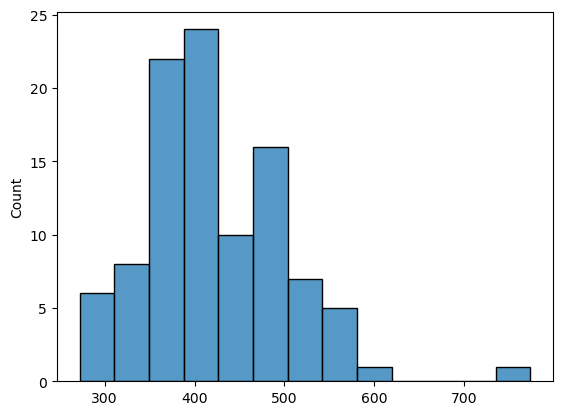

Counter({6328: 3, 6314: 2, 6131: 2, 6230: 2, 6271: 2, 6338: 2, 6148: 2, 6231: 2, 6099: 2, 6262: 2, 5942: 1, 5947: 1, 6196: 1, 6221: 1, 6350: 1, 6206: 1, 5944: 1, 6502: 1, 6272: 1, 6372: 1, 6316: 1, 6112: 1, 6037: 1, 6283: 1, 6220: 1, 6226: 1, 6067: 1, 6212: 1, 6236: 1, 6010: 1, 5982: 1, 5968: 1, 6100: 1, 6296: 1, 5888: 1, 6114: 1, 6172: 1, 6155: 1, 6384: 1, 6382: 1, 6486: 1, 6479: 1, 6175: 1, 6234: 1, 6150: 1, 6275: 1, 6214: 1, 6158: 1, 6285: 1, 6139: 1, 5956: 1, 6383: 1, 6393: 1, 5966: 1, 6199: 1, 6071: 1, 6046: 1, 6008: 1, 6282: 1, 6189: 1, 6344: 1, 6144: 1, 6273: 1, 6300: 1, 5989: 1, 6391: 1, 6019: 1, 6333: 1, 6166: 1, 6310: 1, 6153: 1, 6387: 1, 6146: 1, 6252: 1, 6242: 1, 6376: 1, 6104: 1, 6176: 1, 6128: 1, 6224: 1, 6289: 1, 6028: 1, 5992: 1, 6281: 1, 6223: 1, 6302: 1, 6209: 1, 6342: 1, 6303: 1})


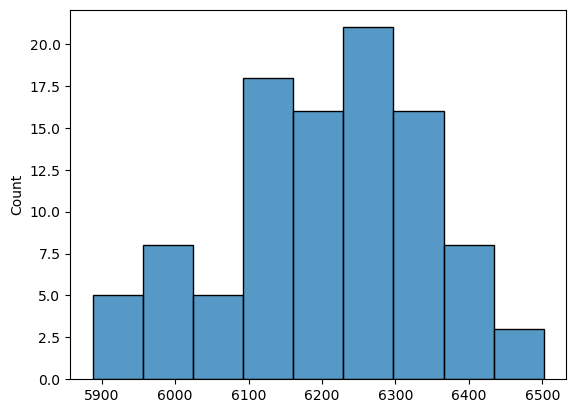

In [57]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

# max_depth
from collections import Counter

print(Counter([x.get_depth() for x in model.estimators_]))


import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot([x.get_depth() for x in model.estimators_])
plt.show()

# max_leaf_nodes
from collections import Counter

print(Counter([x.get_n_leaves() for x in model.estimators_]))


import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot([x.get_n_leaves() for x in model.estimators_])
plt.show()

In [58]:
%%time

model = RandomForestClassifier()

params = {"n_estimators"           : [100, 150], # Numero de arboles
          "criterion"              : ["gini"], # Es la función para medir la calidad de una división/split.
          "max_depth"              : range(350, 600, 200), # La profundidad máxima del árbol.
          "max_features"           : ["sqrt"], # El número de características (atributos) a considerar en cada split
          "max_leaf_nodes"         : range(6000, 6300, 200), # Maximo de nodos hoja del arbol
          "min_samples_split"      : [2, 6] # El número mínimo de muestras requeridas para llegar a nodo hoja.
          } 

scorers = {"roc_auc" : make_scorer(roc_auc_score, needs_proba = True, multi_class = "ovr")}

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "roc_auc" ,
                           n_jobs     = 6         ,
                           verbose    = 3)

model_result = grid_solver.fit(X_train, y_train)

yhat = model_result.best_estimator_.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 50.1 s
Wall time: 33min 32s


In [59]:
print("*"*100)

print(confusion_matrix(y_test, yhat))
matrix_sentimiento = confusion_matrix(y_test, yhat)

print("*"*100)

print(model_result.cv_results_["mean_test_roc_auc"].mean())

print("*"*100)

print(model_result.best_params_)

****************************************************************************************************
[[2457  338  113]
 [ 440 1560  250]
 [ 285  419 1546]]
****************************************************************************************************
0.8914654969115965
****************************************************************************************************
{'criterion': 'gini', 'max_depth': 350, 'max_features': 'sqrt', 'max_leaf_nodes': 6000, 'min_samples_split': 6, 'n_estimators': 150}


In [60]:
# Mejores parámetros
model_result.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 350,
 'max_features': 'sqrt',
 'max_leaf_nodes': 6000,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [61]:
# Guardamos la matriz de confusión
with open("data/matrix_sentimiento.pkl", "bw") as file:
    pkl.dump(matrix_sentimiento, file)

In [62]:
# Guardamos el mejor modelo con sus mejores parámetros
mejor_modelo_sentimiento = RandomForestClassifier(**model_result.best_params_)
mejor_modelo_sentimiento.fit(X_train, y_train)

with open("data/mejor_modelo_sentimiento.pkl", "bw") as file:
    pkl.dump(mejor_modelo_sentimiento, file)
    
# Mostramos ROC AUC con los mejores parámetros
yhat_forest_sentimiento = mejor_modelo_sentimiento.predict_proba(X_test)
print("roc_auc:", roc_auc_score(y_test, yhat_forest_sentimiento, multi_class = "ovr"))

roc_auc: 0.8990718236578568


### 2. Validamos "Emociones"

In [63]:
X = df_tweets.drop(["Emociones", "Sentimientos"], axis = 1)
y = df_tweets["Emociones"]

with open("data/x_scaler_emocion.pkl", "br") as file:
    x_scaler_emocion = pkl.load(file)

X = x_scaler_emocion.fit_transform(X)

# SMOTE
oversampling = SMOTE(sampling_strategy = {0 : 7029, 
                                          3 : 6095, 
                                          1 : 4946,
                                          2 : 2844,
                                          5 : 2000,
                                          4 : 2000})
X_balanceado, y_balanceado = oversampling.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado,
                                                    test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = y_balanceado)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (17439, 8976), y_train: (17439,)
X_test: (7475, 8976),  y_test: (7475,)


Counter({400: 2, 343: 2, 381: 2, 498: 2, 367: 2, 384: 2, 332: 2, 523: 2, 450: 2, 360: 2, 478: 1, 449: 1, 371: 1, 443: 1, 402: 1, 451: 1, 515: 1, 387: 1, 469: 1, 474: 1, 391: 1, 308: 1, 511: 1, 394: 1, 542: 1, 422: 1, 519: 1, 345: 1, 506: 1, 464: 1, 496: 1, 390: 1, 467: 1, 368: 1, 490: 1, 613: 1, 423: 1, 417: 1, 550: 1, 452: 1, 493: 1, 599: 1, 434: 1, 624: 1, 399: 1, 654: 1, 427: 1, 567: 1, 435: 1, 414: 1, 626: 1, 430: 1, 433: 1, 357: 1, 348: 1, 442: 1, 546: 1, 397: 1, 465: 1, 408: 1, 501: 1, 424: 1, 477: 1, 557: 1, 393: 1, 432: 1, 389: 1, 472: 1, 350: 1, 455: 1, 410: 1, 552: 1, 425: 1, 457: 1, 526: 1, 447: 1, 494: 1, 333: 1, 409: 1, 473: 1, 377: 1, 445: 1, 421: 1, 428: 1, 418: 1, 406: 1, 416: 1, 403: 1, 420: 1, 543: 1})


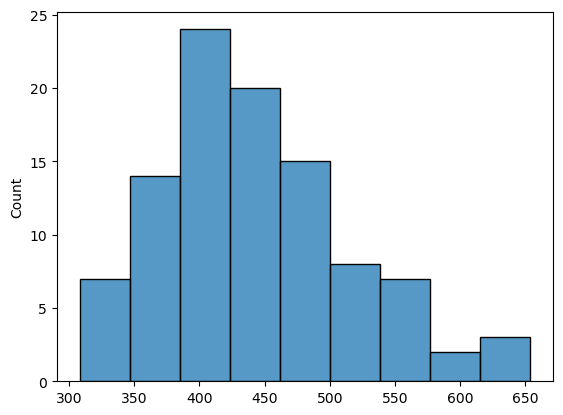

Counter({7493: 3, 7367: 3, 7370: 2, 7418: 2, 7430: 2, 7593: 2, 7346: 2, 7410: 2, 7233: 2, 7470: 2, 7551: 2, 7459: 2, 7516: 2, 7435: 1, 7187: 1, 7282: 1, 7334: 1, 7433: 1, 7595: 1, 7558: 1, 7379: 1, 7351: 1, 7228: 1, 7571: 1, 7666: 1, 7354: 1, 7359: 1, 7417: 1, 7585: 1, 7332: 1, 7371: 1, 7515: 1, 7406: 1, 7241: 1, 7488: 1, 7451: 1, 7446: 1, 7457: 1, 7577: 1, 7545: 1, 7307: 1, 7320: 1, 7357: 1, 7481: 1, 7615: 1, 7468: 1, 7254: 1, 7461: 1, 7426: 1, 7582: 1, 7467: 1, 7442: 1, 7476: 1, 7378: 1, 7539: 1, 7739: 1, 7592: 1, 7606: 1, 7580: 1, 7611: 1, 7450: 1, 7275: 1, 7283: 1, 7428: 1, 7491: 1, 7443: 1, 7629: 1, 7462: 1, 7477: 1, 7552: 1, 7414: 1, 7225: 1, 7388: 1, 7413: 1, 7596: 1, 7182: 1, 7260: 1, 7504: 1, 7643: 1, 7458: 1, 7566: 1, 7538: 1, 7594: 1, 7383: 1, 7521: 1})


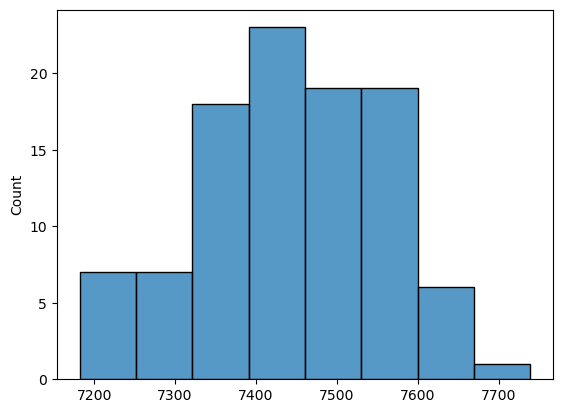

In [64]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

# max_depth
from collections import Counter

print(Counter([x.get_depth() for x in model.estimators_]))


import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot([x.get_depth() for x in model.estimators_])
plt.show()

# max_leaf_nodes
from collections import Counter

print(Counter([x.get_n_leaves() for x in model.estimators_]))


import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot([x.get_n_leaves() for x in model.estimators_])
plt.show()

In [65]:
%%time

model = RandomForestClassifier()

params = {"n_estimators"           : [100, 150], # Numero de arboles
          "criterion"              : ["gini"], # Es la función para medir la calidad de una división/split.
          "max_depth"              : range(350, 500, 100), # La profundidad máxima del árbol.
          "max_features"           : ["sqrt"], # El número de características (atributos) a considerar en cada split
          "max_leaf_nodes"         : range(7400, 7550, 100), # Maximo de nodos hoja del arbol
          "min_samples_split"      : [2, 6] # El número mínimo de muestras requeridas para llegar a nodo hoja.
          }  

scorers = {"roc_auc" : make_scorer(roc_auc_score, needs_proba = True, multi_class = "ovr")}

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "roc_auc" ,
                           n_jobs     = 6         ,
                           verbose    = 3)

model_result = grid_solver.fit(X_train, y_train)

yhat = model_result.best_estimator_.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 28.9 s
Wall time: 34min 48s


In [66]:
print("*"*100)

print(confusion_matrix(y_test, yhat))
matrix_emocion = confusion_matrix(y_test, yhat)

print("*"*100)

print(model_result.cv_results_["mean_test_roc_auc"].mean())

print("*"*100)

print(model_result.best_params_)

****************************************************************************************************
[[1836  128   13  128    0    4]
 [ 260  895   27  288    7    7]
 [ 463  199   73  104    1   13]
 [ 150  349   19 1302    3    6]
 [  88   96    2   99  302   13]
 [ 166   88   24   56    8  258]]
****************************************************************************************************
0.8667261647564811
****************************************************************************************************
{'criterion': 'gini', 'max_depth': 350, 'max_features': 'sqrt', 'max_leaf_nodes': 7400, 'min_samples_split': 6, 'n_estimators': 150}


In [67]:
# Mejores parámetros
model_result.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 350,
 'max_features': 'sqrt',
 'max_leaf_nodes': 7400,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [68]:
# Guardamos la matriz de confusión
with open("data/matrix_emocion.pkl", "bw") as file:
    pkl.dump(matrix_emocion, file)

In [69]:
# Guardamos el mejor modelo con sus mejores parámetros
mejor_modelo_emocion = RandomForestClassifier(**model_result.best_params_)
mejor_modelo_emocion.fit(X_train, y_train)

with open("data/mejor_modelo_emocion.pkl", "bw") as file:
    pkl.dump(mejor_modelo_emocion, file)
    
# Mostramos ROC AUC con los mejores parámetros
yhat_forest_emocion = mejor_modelo_emocion.predict_proba(X_test)
print("roc_auc:", roc_auc_score(y_test, yhat_forest_emocion, multi_class = "ovr"))

roc_auc: 0.8791288505904739


In [70]:
####################################################siguiente-notebook####################################################